## Dataset

In [ ]:
!pip install torchvision
!pip install tools21cm
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
from PIL import Image, ImageOps, ImageFilter
from google.colab.patches import cv2_imshow
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torch.utils.data import Dataset
import toarch.nn.functional as F
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from torch import optim, Tensor
import torch.nn as nn
from tqdm import tqdm
import torchmetrics
import numpy as np
import torchvision
import random
import torch
import cv2
import os

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_dir = "/content/drive/MyDrive/data/data/dataset/"

In [ ]:
class HaloDataSet(Dataset):
    def __init__(self, dataset_dir, mode='train'):
        if mode not in ['train', 'test', 'validation']:
              raise ValueError("Mode must be 'train', 'test', or 'validation'.")

        self.root = dataset_dir

        self.halo_samples_dir = os.path.join(self.root, mode,'halo_slices')
        self.density_samples_dir = os.path.join(self.root, mode,'t21cm_slices')
        self.density_samples = os.listdir(self.density_samples_dir)
        self.halo_samples = os.listdir(self.halo_samples_dir)

        self.transforms = v2.Compose([
        v2.Resize((336, 336)),
        v2.ToTensor(),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])


    def _load_image(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index, add_noise=True):

        density_sample = cv2.imread(os.path.join(self.density_samples_dir, self.density_samples[index]))
        density_sample = cv2.resize(density_sample, (336, 336))

        halo_sample = cv2.imread(os.path.join(self.halo_samples_dir, self.halo_samples[index]))
        halo_sample = cv2.cvtColor(halo_sample, cv2.COLOR_BGR2GRAY)

        label = self.process_labels(halo_sample)
        density_sample = self.transforms(density_sample)

        return density_sample, torch.from_numpy(label).long()

    def process_labels(self, gray):

      gray = cv2.resize(gray, (336, 336))
      blurred = cv2.GaussianBlur(gray, (3, 3), 0)

      _, binary = cv2.threshold(blurred, blurred.mean(), 255, cv2.THRESH_BINARY)

      kernel = np.ones((3,3), np.uint8)
      dilated = cv2.dilate(binary, kernel, iterations=1)

      contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      areas = [cv2.contourArea(contour) for contour in contours]
      average_area = sum(areas) / len(areas) if areas else 0

      high_posibility_masses = np.zeros_like(gray)
      low_posibility_masses = np.zeros_like(gray)

      for contour in contours:
          if  cv2.contourArea(contour) > average_area + (max(areas) - min(areas)) / 4:
              cv2.drawContours(high_posibility_masses, [contour], -1, 255, thickness=cv2.FILLED)
          elif  average_area < cv2.contourArea(contour) < average_area + (max(areas) - min(areas)) / 4:
              cv2.drawContours(low_posibility_masses, [contour], -1, 255, thickness=cv2.FILLED)

      label = np.ones((2, 336, 336))
      label[0] = low_posibility_masses * 1
      label[1] = high_posibility_masses * 1
      return label

    def __len__(self):
        return len(self.density_samples)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


(-0.5, 335.5, 335.5, -0.5)

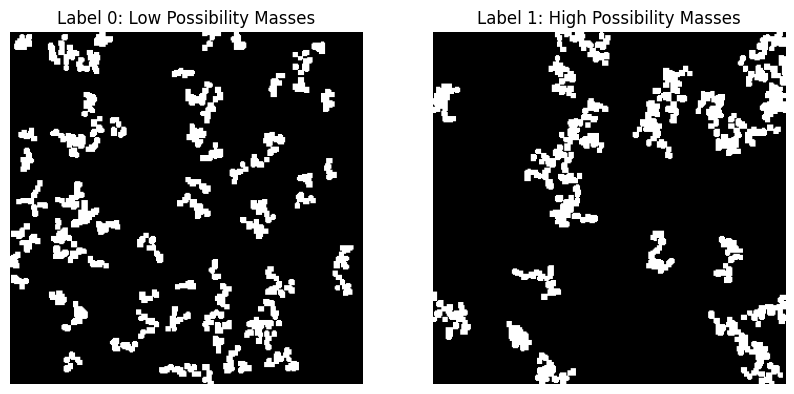

In [ ]:
dataset = HaloDataSet(dataset_dir, mode='train')

_, label = dataset[0]

label_0 = label[0].numpy()
label_1 = label[1].numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(label_0, cmap='gray')
axs[0].set_title('Label 0: Low Possibility Masses')
axs[0].axis('off')

axs[1].imshow(label_1, cmap='gray')
axs[1].set_title('Label 1: High Possibility Masses')
axs[1].axis('off')

In [ ]:
test_size = int(0.1 * len(dataset))
train_size = len(dataset) - test_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, drop_channels=True):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        if drop_channels:
            self.double_conv.append(nn.Dropout2d(p=0.1))

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class DownSamplerBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

NameError: name 'nn' is not defined

In [ ]:
class UpSamplerBlock(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

In [ ]:
class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [ ]:
class BayesianUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(BayesianUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64, drop_channels=False)
        self.down1 = DownSamplerBlock(64, 128)
        self.down2 = DownSamplerBlock(128, 256)
        self.down3 = DownSamplerBlock(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = DownSamplerBlock(512, 1024 // factor)
        self.up1 = UpSamplerBlock(1024, 512 // factor, bilinear)
        self.up2 = UpSamplerBlock(512, 256 // factor, bilinear)
        self.up3 = UpSamplerBlock(256, 128 // factor, bilinear)
        self.up4 = UpSamplerBlock(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [ ]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]

In [ ]:
def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]

NameError: name 'Tensor' is not defined

In [ ]:
def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
net = BayesianUNet(n_channels=3, n_classes=2, bilinear=True).to(device)

In [ ]:
optimiser = optim.Adam(net.parameters(), lr=1e-2, weight_decay=0)

In [ ]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'max', patience=20)
grad_scaler = torch.cuda.amp.GradScaler(enabled=True)

In [ ]:
cross_entropy = nn.CrossEntropyLoss()
epochs = 10

In [ ]:
global_step = 0
for epoch in range(epochs):
    net.train()
    epoch_loss = 0
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{epochs}', unit='batch') as pbar:
        for batch in train_loader:
            images = batch[0].to(device=device, dtype=torch.float32)
            true_masks = batch[1].to(device=device, dtype=torch.float32)

            with torch.cuda.amp.autocast(enabled=True):
                masks_pred = net(images)
                loss = cross_entropy(masks_pred, true_masks) \
                    + dice_loss(F.softmax(masks_pred, dim=1).float(),
                                true_masks,
                                multiclass=True)

            optimiser.zero_grad(set_to_none=True)
            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimiser)
            grad_scaler.update()

            global_step += 1
            epoch_loss += loss.item()

    print(f'Epoch {epoch + 1} completed with average loss: {epoch_loss / len(train_loader):.4f}')

    torch.save(net.state_dict(), f'model_epoch_{epoch + 1}.pth')

Epoch 1/10:   0%|          | 0/26 [00:00<?, ?batch/s]

X torch.Size([32, 3, 336, 336])
DOWN X1 torch.Size([32, 64, 336, 336])
DOWN 1 X2 torch.Size([32, 128, 168, 168])
DOWN 2 X3 torch.Size([32, 256, 84, 84])
DOWN 3 X4 torch.Size([32, 512, 42, 42])
DOWN 4 X5 torch.Size([32, 512, 21, 21])
UP 1 torch.Size([32, 256, 42, 42])
UP 2 torch.Size([32, 128, 84, 84])
UP 3 torch.Size([32, 64, 168, 168])
UP 4 torch.Size([32, 64, 336, 336])
Out torch.Size([32, 64, 336, 336])
X torch.Size([32, 3, 336, 336])
DOWN X1 torch.Size([32, 64, 336, 336])
DOWN 1 X2 torch.Size([32, 128, 168, 168])
DOWN 2 X3 torch.Size([32, 256, 84, 84])
DOWN 3 X4 torch.Size([32, 512, 42, 42])
DOWN 4 X5 torch.Size([32, 512, 21, 21])
UP 1 torch.Size([32, 256, 42, 42])
UP 2 torch.Size([32, 128, 84, 84])
UP 3 torch.Size([32, 64, 168, 168])
UP 4 torch.Size([32, 64, 336, 336])
Out torch.Size([32, 64, 336, 336])


Epoch 1/10:   0%|          | 0/26 [00:35<?, ?batch/s]


KeyboardInterrupt: 

In [ ]:
def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]

In [ ]:
def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]

In [ ]:
def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [ ]:
def accuracy_coeff(preds, target, num_classes):
    return torchmetrics.functional.accuracy(preds = preds,
                                            target = target,
                                            average='macro',
                                            threshold=0.5,
                                            top_k=1,
                                            task='multiclass',
                                            num_classes=num_classes,
                                            ignore_index=None)

In [ ]:
def multiclass_accuracy(preds, target, num_classes):
    return torchmetrics.functional.accuracy(preds = preds,
                                            target = target,
                                            average=None,
                                            threshold=0.5,
                                            top_k=1,
                                            num_classes=num_classes,
                                            task='multiclass',
                                            ignore_index=None)

In [ ]:
def F1_score(preds, target, num_classes):
    return torchmetrics.functional.f1_score(preds,
                        target,
                        num_classes=num_classes,
                        threshold=0.5,
                        average=None,
                        ignore_index=None,
                        top_k=1,
                        task='multiclass'
                        )

In [ ]:
def evaluate_uncertainty(net,
                        dataloader,
                        device,
                        nb_forward):
    net.eval()
    enable_dropout(net)
    num_val_batches = len(dataloader)
    dice_score = 0
    accuracy_score = 0
    accuracy_per_class = 0
    F1_coeff_per_class  = 0
    IOU_coeff = 0
    IOU_coeff_per_class = 0
    cf_matrix = np.zeros(shape = (net.n_classes,net.n_classes))
    pa = 0
    pu = 0
    pavpu = 0

    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
        image, mask_true = batch[0], batch[1]

        image = image.to(device=device, dtype=torch.float32)
        mask_true = mask_true.to(dtype=torch.float32)

        dropout_predictions = torch.empty((0,mask_true.size(0),mask_true.size(1),mask_true.size(2),mask_true.size(3)))

        for f_pass in range(nb_forward):
            with torch.no_grad():
                mask_pred = net(image)

                dropout_predictions = torch.cat((dropout_predictions,mask_pred.cpu().softmax(dim=1).unsqueeze(dim=0)),dim=0)

        batch_mean = dropout_predictions.mean(dim=0)
        batch_std = dropout_predictions.std(dim=0)
        batch_pred_entropy = -torch.sum(batch_mean*batch_mean.log(),dim=1)
        batch_mutual_info = batch_pred_entropy+torch.mean(torch.sum(dropout_predictions*dropout_predictions.log(),dim=-3),dim=0)

        mask_pred_labels = batch_mean.argmax(dim=1)
        mask_true_labels = mask_true.argmax(dim=1)

        accuracy_score += accuracy_coeff(mask_pred_labels, mask_true_labels, num_classes = net.n_classes)
        accuracy_per_class += multiclass_accuracy(mask_pred_labels, mask_true_labels, num_classes = net.n_classes)
        F1_coeff_per_class += F1_score(mask_pred_labels, mask_true_labels, num_classes= net.n_classes)

        mask_pred_onehot = F.one_hot(mask_pred_labels, net.n_classes).permute(0,3,1,2).float()
        dice_score += multiclass_dice_coeff(mask_pred_onehot[:, 1:, ...],
                                                    mask_true[:, 1:, ...],
                                                    reduce_batch_first=False)


        w_size = 4
        accuracy_tresh = 0.5

        unfold = torch.nn.Unfold(kernel_size=(w_size, w_size),stride = w_size)

        masktrue_unfold = unfold(mask_true_labels.unsqueeze(dim=1).to(torch.float32))
        pred_unfold = unfold(mask_pred_labels.unsqueeze(dim=1).to(torch.float32))
        accuracy_matrix = torch.eq(pred_unfold, masktrue_unfold).to(torch.float32).mean(dim=1)
        bool_acc_matrix = torch.gt(accuracy_matrix, accuracy_tresh).to(torch.float32)

        uncertainty_matrix = unfold(batch_pred_entropy.unsqueeze(dim=1)).mean(dim=1)
        t = 0.4
        uncertainty_tresh = uncertainty_matrix.min()+t*(uncertainty_matrix.max()-uncertainty_matrix.min())
        bool_uncert_matrix = torch.gt(uncertainty_matrix, uncertainty_tresh).to(torch.float32)

        nac = (bool_acc_matrix*(1-bool_uncert_matrix)).sum()
        nac_plus_nic = (1-bool_uncert_matrix).sum()
        niu = (bool_uncert_matrix*(1-bool_acc_matrix)).sum()
        nic_plus_niu = (1-bool_acc_matrix).sum()
        pa += nac/nac_plus_nic
        pu += niu/nic_plus_niu
        pavpu += (nac+niu) / torch.ones_like(bool_acc_matrix).sum()

    cf_matrix = cf_matrix/cf_matrix.sum(axis=1,keepdims=True)

    net.train()
    return (dice_score/num_val_batches,
            accuracy_score/num_val_batches,
            accuracy_per_class/num_val_batches,
            F1_coeff_per_class/num_val_batches,
            cf_matrix,
            pa/num_val_batches,
            pu/num_val_batches,
            pavpu/num_val_batches)


def enable_dropout(model):
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

test_dl = test_loader

net = BayesianUNet(n_channels=3, n_classes=2, bilinear=True).to(device=device)

checkpoint_path = '/content/model_epoch_10.pth'
net.load_state_dict(torch.load(checkpoint_path, map_location=device))
net.eval()

(val_score,
accuracy_score,
accuracy_per_class,
F1_score,
cf_matrix,
pa,
pu,
pavpu) = evaluate_uncertainty(net,test_dl,device, nb_forward=10)

print(f'Validation Dice score : {val_score}')
print(f'Global accuracy score : {accuracy_score}')
print(f'F1 score : {F1_score}')
print(f'Classwise accuracy score : {accuracy_per_class}')
print(f'Pa score : {pa}')
print(f'Pu score : {pu}')
print(f'PavPu score : {pavpu}')

<ipython-input-27-573c7ef06ddb>:74: RuntimeWarning: invalid value encountered in divide
  cf_matrix = cf_matrix/cf_matrix.sum(axis=1,keepdims=True)


Validation Dice score : 1.349998116493225
Global accuracy score : 0.6754932403564453
F1 score : tensor([0.7687, 0.2923])
Classwise accuracy score : tensor([0.6451, 0.7059])
Pa score : 0.7931773066520691
Pu score : 0.9813516736030579
PavPu score : 0.3764234483242035


In [ ]:
W_SIZE = 4
NB_FORWARD = 20
ACCURACY_THRESH = 0.5
UNCERTAINTY_THRESH = 0.4
CMAP = colors.ListedColormap(["b","r","y","g","m","w"])
CLASSES = ["impervious_surfaces", "buildings", "low_vegetaion", "tree", "car", "background"]
CMAPSCALE = [-0.5,0.5,1.5,2.5,3.5,4.5,5.5]

def enable_dropout(model):
	for m in model.modules():
		if m.__class__.__name__.startswith('Dropout'):
			m.train()

def disable_dropout(model):
	for m in model.modules():
		if m.__class__.__name__.startswith('Dropout'):
			m.eval()

def predict(net, inputs, targets=None, device="cpu", normalization_mean=0, normalization_std=1):
  if targets==None:
    usetargets = False
  else:
    usetargets = True
  doc = inputs.clone().detach().to(device=device)
  dropout_predictions = torch.empty((0,targets.size(0),targets.size(1),targets.size(2),targets.size(3)))

  for f_pass in range(NB_FORWARD):
    with torch.no_grad():
      enable_dropout(net)
      mask_pred = net(doc)
      dropout_predictions = torch.cat((dropout_predictions,mask_pred.cpu().softmax(dim=1).unsqueeze(dim=0)),dim=0)

  batch_mean = dropout_predictions.mean(dim=0)
  batch_std = dropout_predictions.std(dim=0)
  batch_pred_entropy = -torch.sum(batch_mean*batch_mean.log(),dim=1)
  batch_mutual_info = batch_pred_entropy+torch.mean(torch.sum(dropout_predictions*dropout_predictions.log(),dim=-3), dim=0)

  if usetargets:
    mask_true = targets.clone().detach()
    mask_pred_labels = batch_mean.argmax(dim=1)
    mask_true_labels = mask_true.argmax(dim=1)

    masktrue_unfold = unfold(mask_true_labels.unsqueeze(dim=1).to(torch.float32))
    pred_unfold = unfold(mask_pred_labels.unsqueeze(dim=1).to(torch.float32))
    accuracy_matrix = torch.eq(pred_unfold, masktrue_unfold).to(torch.float32).mean(dim=1)
    bool_acc_matrix = torch.gt(accuracy_matrix, ACCURACY_THRESH).to(torch.float32)

    uncertainty_matrix = unfold(batch_pred_entropy.unsqueeze(dim=1)).mean(dim=1)
    uncertainty_tresh = uncertainty_matrix.min()+UNCERTAINTY_THRESH*(uncertainty_matrix.max()-uncertainty_matrix.min())
    bool_uncert_matrix = torch.gt(uncertainty_matrix, uncertainty_tresh).to(torch.float32)

    acc_expanded = bool_acc_matrix.view(bool_acc_matrix.size(0),1,bool_acc_matrix.size(1)).expand(bool_acc_matrix.size(0),W_SIZE**2,bool_acc_matrix.size(1))
    uncert_expanded = bool_uncert_matrix.view(bool_uncert_matrix.size(0),1,bool_uncert_matrix.size(1)).expand(bool_uncert_matrix.size(0),W_SIZE**2,bool_uncert_matrix.size(1))

  for j in range(targets.size(0)):
    entropy = batch_pred_entropy[j].cpu().numpy()
    mutual = batch_mutual_info[j].cpu().numpy()
    prediction = batch_mean[j].argmax(dim=0).cpu().numpy()

    bin_acc_map = fold(acc_expanded)[j][0]
    bin_uncert_map = fold(uncert_expanded)[j][0]

    bin_inacc_certain = (1-bin_acc_map)*(1-bin_uncert_map)

    document = doc[j]
    rgbidsm = document[:5,:,:].cpu()*normalization_std+normalization_mean
    rgb = rgbidsm[:3,:,:].cpu().div(torch.max(rgbidsm[:3,:,:])).permute(1,2,0).numpy()
    ir = rgbidsm[1,:,:].cpu().numpy()
    dsm = rgbidsm[2,:,:].cpu().numpy()

    # data image
    fig = plt.figure()
    plt.subplot(131)
    plt.imshow(rgb)
    plt.axis('off')
    plt.title('RGB')
    plt.subplot(132)
    plt.imshow(ir, cmap='Reds', norm=colors.Normalize())
    plt.axis('off')
    plt.title('IR')
    plt.subplot(133)
    plt.imshow(dsm, norm=colors.Normalize())
    plt.axis('off')
    plt.title('DSM')
    plt.tight_layout()
    plt.savefig(f'predictions/prediction{j}_input.png', bbox_inches='tight', pad_inches=0)
    plt.close()

    # prediction image
    fig = plt.figure()
    plt.subplot(131)
    plt.imshow(prediction, cmap=CMAP, norm=colors.BoundaryNorm(CMAPSCALE, len(CMAPSCALE)-1), alpha=1)
    plt.axis('off')
    plt.title('Prediction')
    plt.subplot(132)
    plt.imshow(entropy, vmin=batch_pred_entropy.min().cpu().numpy(), vmax = batch_pred_entropy.max().cpu().numpy())
    plt.axis('off')
    plt.title('Predictive Entropy')
    plt.subplot(133)
    plt.imshow(mutual, vmin=batch_mutual_info.min().cpu().numpy(), vmax = batch_mutual_info.max().cpu().numpy())
    plt.axis('off')
    plt.title('Epistemic Uncertainty')
    plt.tight_layout()
    plt.savefig(f'predictions/prediction{j}_output.png', bbox_inches='tight', pad_inches=0)

    if usetargets:
      # binary maps
      fig = plt.figure()
      plt.subplot(231)
      plt.imshow(mask_true[j].argmax(dim=0).numpy(), cmap=CMAP, norm=colors.BoundaryNorm(CMAPSCALE, len(CMAPSCALE)-1), alpha=1)
      plt.axis('off')
      plt.title('Ground truth')
      plt.subplot(232)
      plt.imshow(prediction, cmap=CMAP, norm=colors.BoundaryNorm(CMAPSCALE, len(CMAPSCALE)-1), alpha=1)
      plt.axis('off')
      plt.title('Prediction')
      plt.subplot(234)
      plt.imshow(bin_acc_map)
      plt.axis('off')
      plt.title('Accuracy (binary)')
      plt.subplot(235)
      plt.imshow(bin_uncert_map)
      plt.axis('off')
      plt.title('Uncertainty (binary)')
      plt.subplot(236)
      plt.imshow(bin_inacc_certain)
      plt.axis('off')
      plt.title('Inaccurate and certain')
      plt.tight_layout()
      plt.savefig(f'predictions/prediction{j}_binarymaps.png', bbox_inches='tight', pad_inches=0)
      plt.close()


if not os.path.exists("./predictions"):
  os.mkdir("./predictions")

dl = test_loader
inputs, targets = next(iter(dl))

checkpoint_path = '/content/model_epoch_10.pth'
net.load_state_dict(torch.load(checkpoint_path, map_location=device))
net.eval()


unfold = torch.nn.Unfold(kernel_size=(W_SIZE, W_SIZE),stride = W_SIZE)
fold = torch.nn.Fold(output_size=(inputs.size(2),inputs.size(3)), kernel_size=(W_SIZE, W_SIZE), stride=W_SIZE)

predict(net=net, inputs=inputs, targets=targets, device=device, normalization_mean=0, normalization_std=1)